In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.utils import plot_model

2025-06-22 12:29:22.371395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750595362.552776      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750595362.611171      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train = '/kaggle/input/chest-ctscan-images/Data/train'
val = '/kaggle/input/chest-ctscan-images/Data/valid'
test = '/kaggle/input/chest-ctscan-images/Data/test'

input_shape = (224, 224, 3)
classes = 4
target_size = (224, 224)
batch_size = 32

In [3]:
train_datagen = ImageDataGenerator(dtype= 'float32',
                                   preprocessing_function= preprocess_input,
                                   rotation_range= 20,
                                   width_shift_range= 0.2,
                                   height_shift_range= 0.2,
                                   shear_range= 0.2,
                                   zoom_range= 0.2,
                                   horizontal_flip= True,
                                   vertical_flip= False)

train_gen = train_datagen.flow_from_directory(train,
                                              target_size= target_size,
                                             batch_size= batch_size,
                                             class_mode= 'categorical')

Found 613 images belonging to 4 classes.


In [4]:
val_datagen = ImageDataGenerator(dtype= 'float32',
                                preprocessing_function= preprocess_input)

val_gen = val_datagen.flow_from_directory(val,
                                         target_size= target_size,
                                         batch_size= batch_size,
                                         class_mode= 'categorical')

Found 72 images belonging to 4 classes.


In [5]:
test_datagen = ImageDataGenerator(dtype= 'float32',
                                 preprocessing_function= preprocess_input)

test_gen = test_datagen.flow_from_directory(test,
                                           target_size= target_size,
                                           batch_size= batch_size,
                                           class_mode= 'categorical')

Found 315 images belonging to 4 classes.


In [6]:
base_model = ResNet50(include_top= False, pooling= 'av',
                     weights= 'imagenet', input_shape= (input_shape))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation= 'relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation= 'softmax'))

model.summary()

I0000 00:00:1750595378.500948      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100352)              │         401,408 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,680,516 (189.52 MB)

 Trainable params: 25,892,100 (98.77 MB)

 Non-trainable params: 23,788,416 (90.75 MB)

In [7]:
optimizer = Adam()
model_name = 'Chest CT-Scan Lung Cancer Detection'
model.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics= ['accuracy'])

checkpoint = ModelCheckpoint(filepath= f'{model_name}.h5',
                            monitor= 'val_loss', save_best_only= True,
verbose= 1)

earlystop = EarlyStopping(patience= 10, verbose= 1)

In [8]:
hist = model.fit(train_gen, validation_data= test_gen,
                 epochs= 50, callbacks= [checkpoint, earlystop],
                verbose= 1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1750595393.858150      81 service.cc:148] XLA service 0x7ab8f4013bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750595393.858928      81 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750595395.409470      81 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/20 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2500 - loss: 4.5043 

I0000 00:00:1750595399.701150      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.4259 - loss: 12.3476
Epoch 1: val_loss improved from inf to 107.83951, saving model to Chest CT-Scan Lung Cancer Detection.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.4283 - loss: 12.5406 - val_accuracy: 0.3333 - val_loss: 107.8395
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.5592 - loss: 14.2939
Epoch 2: val_loss improved from 107.83951 to 38.96783, saving model to Chest CT-Scan Lung Cancer Detection.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 597ms/step - accuracy: 0.5612 - loss: 14.2192 - val_accuracy: 0.4190 - val_loss: 38.9678
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.6696 - loss: 8.9248
Epoch 3: val_loss improved from 38.96783 to 18.95315, saving model to Chest CT-Scan Lung Cancer Detection.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 620ms/step - accuracy: 0.6698 - loss: 8.9363 - val_accuracy: 0.5302 - val_loss: 18.9532
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.6678

In [9]:
hist1 = model.fit(train_gen, validation_data= test_gen,
                 epochs= 100, callbacks= [checkpoint, earlystop],
                verbose= 1)

Epoch 1/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.8521 - loss: 0.5828
Epoch 1: val_loss did not improve from 0.80599
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 536ms/step - accuracy: 0.8536 - loss: 0.5933 - val_accuracy: 0.7651 - val_loss: 0.8836
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8648 - loss: 0.6590
Epoch 2: val_loss did not improve from 0.80599
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 503ms/step - accuracy: 0.8655 - loss: 0.6602 - val_accuracy: 0.7873 - val_loss: 0.8082
Epoch 3/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.8423 - loss: 0.7648
Epoch 3: val_loss did not improve from 0.80599
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 505ms/step - accuracy: 0.8435 - loss: 0.7811 - val_accuracy: 0.7683 - val_loss: 0.8502
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8818 - loss: 0.4926
Epoch 4: val_loss did not improve from 0.80599
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 522ms/step - accuracy: 0.8818 - loss: 0.4896 - val_accuracy: 0.7492 - val_loss:

In [10]:
result = model.evaluate(val_gen)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9023 - loss: 0.6608


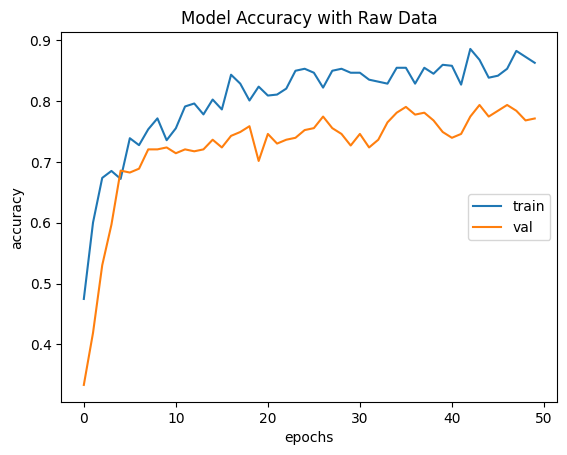

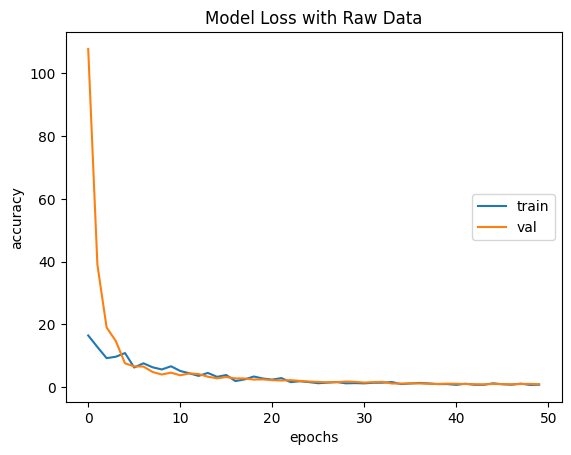

In [11]:
plt.plot(hist.history['accuracy'], label = 'train',)
plt.plot(hist.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Model Accuracy with Raw Data')
plt.savefig(f'images\\accuracy.png')
plt.show()

plt.plot(hist.history['loss'], label = 'train',)
plt.plot(hist.history['val_loss'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Model Loss with Raw Data')
plt.savefig(f'images\\loss.png')
plt.show()

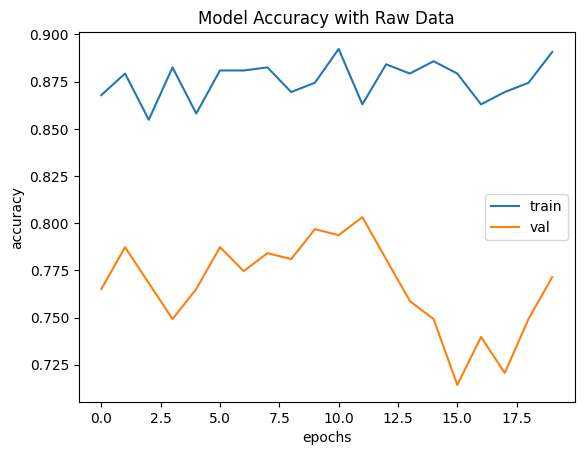

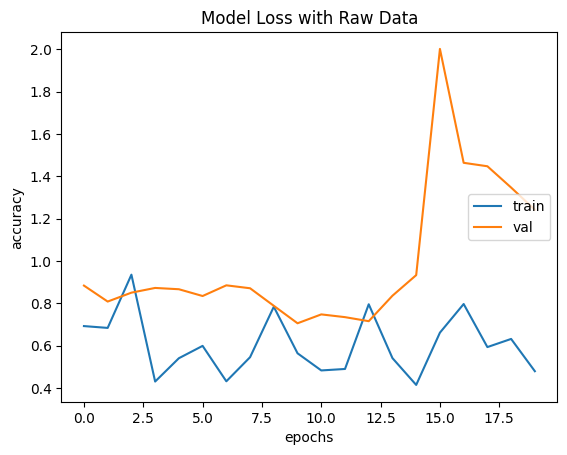

In [12]:
plt.plot(hist1.history['accuracy'], label = 'train',)
plt.plot(hist1.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Model Accuracy with Raw Data')
plt.savefig(f'images\\accuracy.png')
plt.show()

plt.plot(hist1.history['loss'], label = 'train',)
plt.plot(hist1.history['val_loss'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Model Loss with Raw Data')
plt.savefig(f'images\\loss.png')
plt.show()